<a href="https://colab.research.google.com/github/KillShotAK/UoS-Forex-Trading-Robot/blob/main/Interconnected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta
!pip install matplotlib
!pip install scikit-learn
!pip install --upgrade matplotlib
!pip install pandas numpy scikit-learn ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=e249512749f42f4881170709bb22ab6f3dcea734663dcd4042dc2a4d5b6cdfa5
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

import ta

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset from the Excel file
file_path = '/content/EURUSD_prices_Hourly.xlsx'  # Update this with your file path
data = pd.read_excel(file_path, engine='openpyxl')

Label Distribution for Each Method:

Label_Threshold:
Label_Threshold
up      0.506351
down    0.493587
hold    0.000062
Name: proportion, dtype: float64

Label_StdDev:
Label_StdDev
hold    0.470835
up      0.266556
down    0.262609
Name: proportion, dtype: float64

Label_Directional:
Label_Directional
up      0.506351
down    0.493587
hold    0.000062
Name: proportion, dtype: float64

Label_PriceChangeDirection:
Label_PriceChangeDirection
up      0.511222
down    0.481934
hold    0.006844
Name: proportion, dtype: float64

Label_Volatility:
Label_Volatility
hold    0.470835
up      0.266556
down    0.262609
Name: proportion, dtype: float64

Agreement between all methods: 52.71%

Relationship between Label_Threshold and Intra_Period_Dynamics:
Intra_Period_Dynamics      doji  indecisive  lower_rejection  strong_trend  \
Label_Threshold                                                              
down                   0.000000    0.034104         0.248720      0.312804   
hold          

<ipython-input-10-404ea0e4093c>:106: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


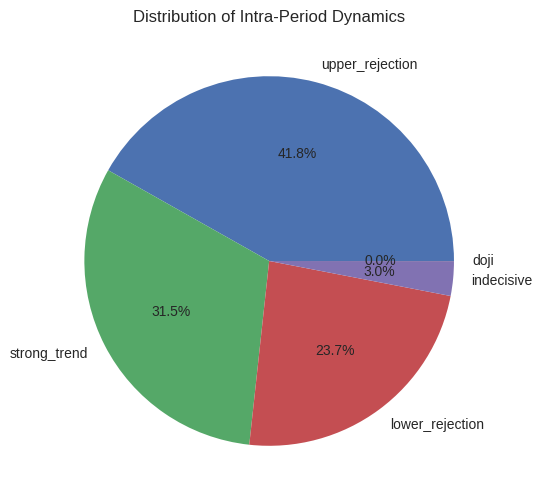

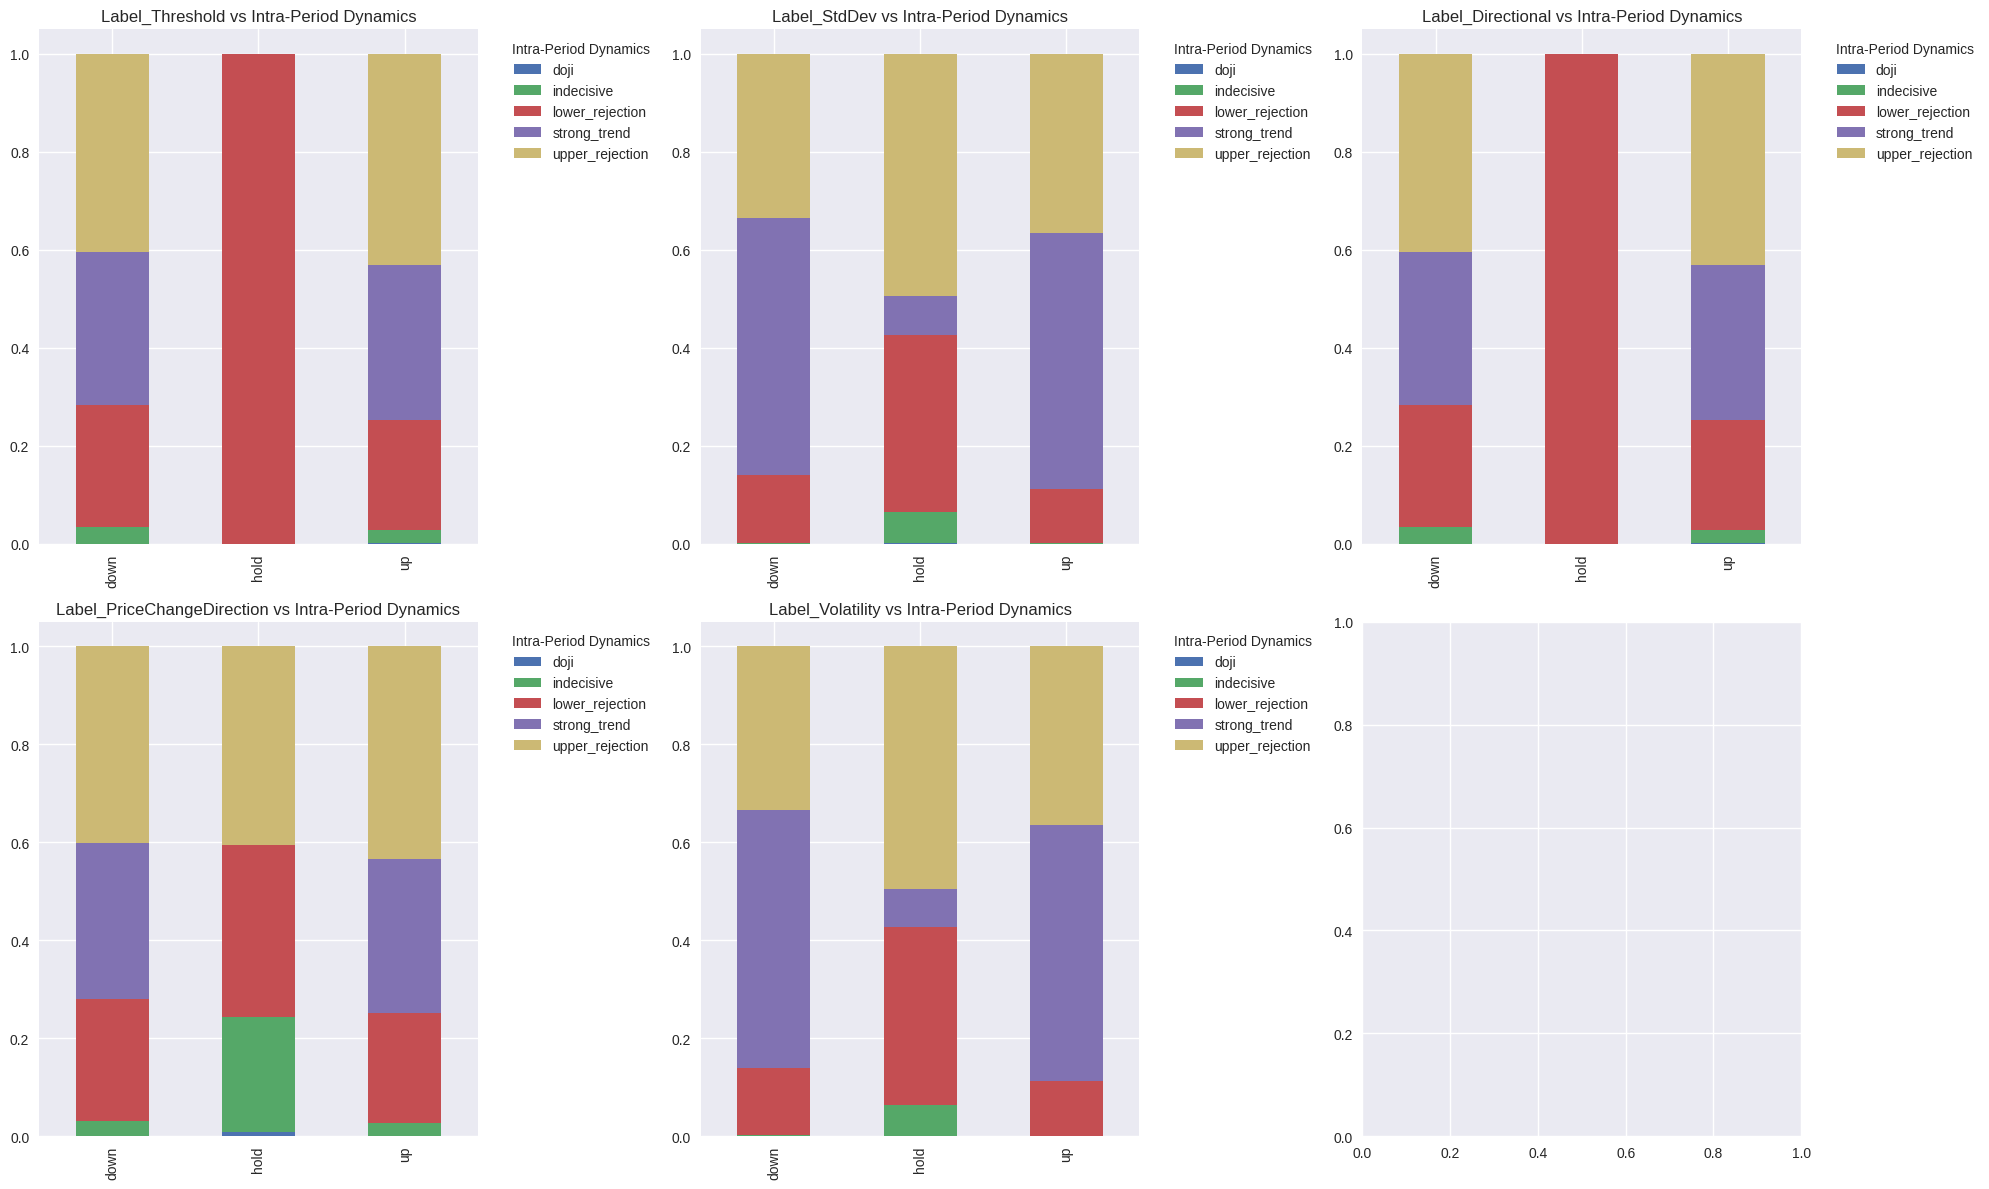

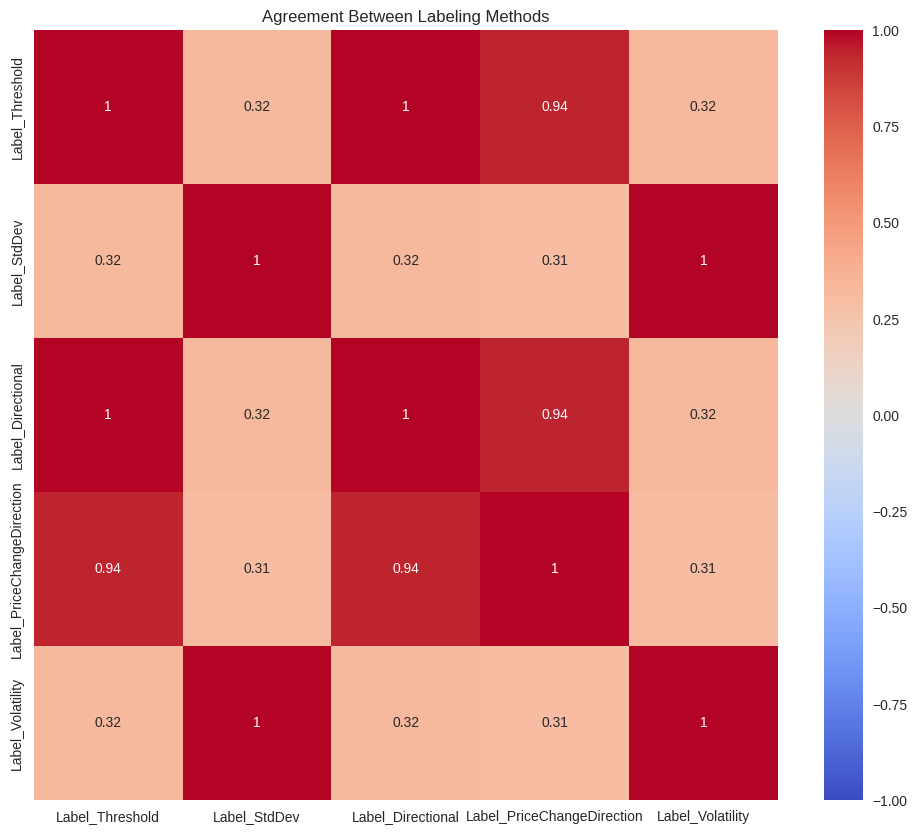

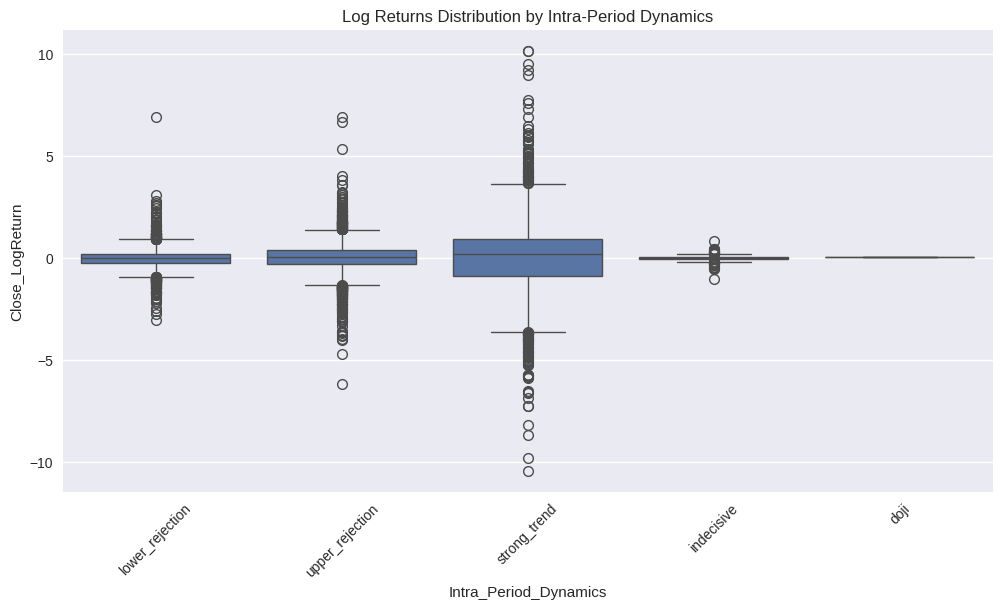

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:
# Calculate log returns for price columns
price_columns = ['Close', 'Open', 'High', 'Low']
for col in price_columns:
    data[f'{col}_LogReturn'] = np.log(data[col] / data[col].shift(1))

# Calculate percentage change for Volume
data['Volume_Pct_Change'] = data['Volume'].pct_change()

# Prepare features for scaling
features = ['Close_LogReturn', 'Open_LogReturn', 'High_LogReturn', 'Low_LogReturn',
            'Volume_Pct_Change', 'stochastic', 'momentum', 'wiliams', 'ADI', 'EMA',
            'MACD', 'RSI', 'on_balance_volume', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'ATR']

# Apply StandardScaler
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Labeling methods

def adjusted_threshold_method(log_return, threshold=0.0001):
    if log_return > threshold:
        return "up"
    elif log_return < -threshold:
        return "down"
    else:
        return "hold"

def adjusted_std_dev_method(log_returns, window=20, multiplier=0.5):
    rolling_std = log_returns.rolling(window=window).std()
    threshold = multiplier * rolling_std
    return np.where(log_returns > threshold, "up",
                    np.where(log_returns < -threshold, "down", "hold"))

def directional_method(log_return):
    if log_return > 0:
        return "up"
    elif log_return < 0:
        return "down"
    else:
        return "hold"

def price_change_direction_method(close, open_price):
    if close > open_price:
        return "up"
    elif close < open_price:
        return "down"
    else:
        return "hold"

def volatility_method(log_returns, window=20, multiplier=0.5):
    rolling_std = log_returns.rolling(window=window).std()
    upper_threshold = multiplier * rolling_std
    lower_threshold = -multiplier * rolling_std
    return np.where(log_returns > upper_threshold, "up",
                    np.where(log_returns < lower_threshold, "down", "hold"))

# Apply labeling methods
data['Label_Threshold'] = data['Close_LogReturn'].apply(adjusted_threshold_method)
data['Label_StdDev'] = adjusted_std_dev_method(data['Close_LogReturn'])
data['Label_Directional'] = data['Close_LogReturn'].apply(directional_method)
data['Label_PriceChangeDirection'] = data.apply(lambda row: price_change_direction_method(row['Close'], row['Open']), axis=1)
data['Label_Volatility'] = volatility_method(data['Close_LogReturn'])

# Function to calculate intra-period dynamics
def intra_period_dynamics(row):
    body = abs(row['Close'] - row['Open'])
    upper_wick = max(row['High'] - row['Close'], row['High'] - row['Open'])
    lower_wick = max(row['Open'] - row['Low'], row['Close'] - row['Low'])
    total_range = row['High'] - row['Low']

    if total_range == 0:
        return "doji"
    elif body / total_range > 0.6:
        return "strong_trend"
    elif upper_wick / total_range > 0.6:
        return "upper_rejection"
    elif lower_wick / total_range > 0.6:
        return "lower_rejection"
    else:
        return "indecisive"

# Apply intra-period dynamics
data['Intra_Period_Dynamics'] = data.apply(intra_period_dynamics, axis=1)

# Compare labeling methods
label_columns = ['Label_Threshold', 'Label_StdDev', 'Label_Directional', 'Label_PriceChangeDirection', 'Label_Volatility']

print("Label Distribution for Each Method:")
for col in label_columns:
    print(f"\n{col}:")
    print(data[col].value_counts(normalize=True))

# Calculate agreement between methods
agreement = data[label_columns].apply(lambda x: x.nunique() == 1, axis=1).mean()
print(f"\nAgreement between all methods: {agreement:.2%}")

# Analyze relationship between intra-period dynamics and labels
for col in label_columns:
    print(f"\nRelationship between {col} and Intra_Period_Dynamics:")
    print(pd.crosstab(data[col], data['Intra_Period_Dynamics'], normalize='index'))

import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn')

# 1. Pie chart for Intra-Period Dynamics distribution
plt.figure(figsize=(10, 6))
data['Intra_Period_Dynamics'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Intra-Period Dynamics')
plt.ylabel('')
plt.show()

# 2. Stacked bar chart for Intra-Period Dynamics vs Labeling Methods
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(label_columns):
    pd.crosstab(data[col], data['Intra_Period_Dynamics'], normalize='index').plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{col} vs Intra-Period Dynamics')
    axes[i].set_xlabel('')
    axes[i].legend(title='Intra-Period Dynamics', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 3. Heatmap of agreement between methods
agreement_matrix = data[label_columns].apply(lambda x: pd.factorize(x)[0]).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(agreement_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Agreement Between Labeling Methods')
plt.show()

# 4. Box plot of log returns for each Intra-Period Dynamic category
plt.figure(figsize=(12, 6))
sns.boxplot(x='Intra_Period_Dynamics', y='Close_LogReturn', data=data)
plt.title('Log Returns Distribution by Intra-Period Dynamics')
plt.xticks(rotation=45)
plt.show()

# 5. Stacked area chart of Intra-Period Dynamics over time
dynamics_over_time = data.set_index('Date')['Intra_Period_Dynamics'].resample('W').value_counts(normalize=True).unstack()
dynamics_over_time.plot(kind='area', stacked=True, figsize=(15, 6))
plt.title('Intra-Period Dynamics Composition Over Time')
plt.ylabel('Proportion')
plt.show()

In [ ]:
data

,Close,Open,Low,High,Volume,Date,stochastic,momentum,wiliams,ADI,...,Open_LogReturn,High_LogReturn,Low_LogReturn,Volume_Pct_Change,Label_Threshold,Label_StdDev,Label_Directional,Label_PriceChangeDirection,Label_Volatility,Intra_Period_Dynamics
0,1.17357,1.17313,1.17233,1.17375,7613,2018-09-24T06:00,-0.375552,-0.823256,-0.375552,2.309722,...,NaN,NaN,NaN,NaN,hold,hold,hold,up,hold,lower_rejection
1,1.17376,1.17354,1.17338,1.17484,10043,2018-09-24T07:00,-0.169450,-0.773116,-0.169450,2.271799,...,0.404550,1.174936,1.136959,-0.003748,up,hold,up,up,hold,upper_rejection
2,1.17669,1.17377,1.17367,1.17679,11376,2018-09-24T08:00,1.619701,-0.648399,1.619701,2.355650,...,0.226128,2.100673,0.312454,-0.094687,up,hold,up,up,hold,strong_trend
3,1.17689,1.17668,1.17626,1.17734,6809,2018-09-24T09:00,1.389402,-0.435405,1.389402,2.364588,...,2.877136,0.590553,2.802257,-0.355215,up,hold,up,up,hold,upper_rejection
4,1.17633,1.17690,1.17621,1.17744,6800,2018-09-24T10:00,0.954080,-0.203837,0.954080,2.321482,...,0.215641,0.105845,-0.055987,-0.160065,down,hold,down,down,hold,upper_rejection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16213,1.20146,1.20104,1.20087,1.20151,2783,2021-05-04T19:00,-0.340223,-0.883605,-0.340223,0.537600,...,-0.785556,-0.824580,-0.203169,-0.156423,up,up,up,up,up,strong_trend
16214,1.20124,1.20146,1.20119,1.20197,1301,2021-05-04T20:00,-0.417168,-0.859191,-0.417168,0.528667,...,0.404788,0.483444,0.337031,-0.419134,down,hold,down,down,hold,upper_rejection
16215,1.20103,1.20113,1.20071,1.20126,77,2021-05-04T21:00,-0.612689,-0.869882,-0.612689,0.528767,...,-0.321097,-0.750922,-0.510357,-0.618264,down,hold,down,down,hold,lower_rejection
16216,1.20153,1.20106,1.20103,1.20153,543,2021-05-04T22:00,-0.147164,-0.863650,-0.147164,0.533043,...,-0.069473,0.283086,0.337076,2.792166,up,up,up,up,up,strong_trend
